In [1]:
import requests
from PIL import Image, ImageDraw, ImageEnhance, ImageFilter
from PIL import ImageOps

import pandas as pd
import io
import os
import re

import random
import math
import itertools

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker

import matplotlib.pyplot as plt
import numpy as np





#from aquarel import load_theme

In [8]:
import mplcyberpunk

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
def parse_tmg(gm_dat, 
              team_mates=['kydo','Orion','Customjc'],
              drop_k = ['player','players_id','clan','division','color']):
    
    df_l = []

    for _, row in gm_dat.iterrows():
        # parse players into a list of series
        plist = []
        opp=0
        tm=0

        for p in row['players']:
            if p['player']['players_name'] =='kydo': 
                ktm = p['team'] 
                continue

        for p in row['players']:

            player = pd.Series(p)
            player['name'] = p['player']['players_name']       
            
            if player['team'] == ktm:
                player = player.drop(drop_k).rename(f'tm_{tm}')
                tm = tm+1
            else:
                player = player.drop(drop_k).rename(f'opp_{opp}')   
                opp = opp+1 

            plist.append(player)

        # parse series into a single dataframe
        p_df = plist[0].to_frame().transpose().reset_index(drop=True).join(
            plist[1].to_frame().transpose().reset_index(drop=True), lsuffix='_'+plist[0].name,
            rsuffix='_'+plist[1].name)

        for p in plist[2:]:
            suff = '_'+p.name
            p_df = p_df.join(p.to_frame().transpose().reset_index(drop=True).add_suffix(suff))

        df_l.append(p_df)

    df_p = pd.concat(df_l).reset_index(drop=True)

    r_df = gm_dat.join(df_p)

    return r_df

In [5]:
def parse_plyr(df_i,
               name, 
               col_k = ['game_length', 'map_name', 'format',
                        'winning_player', 'players', 'seasons_id', 'replay_date',
                        'DateTime','DOY',
                        'race_tm_0', 'mmr_tm_0', 'apm_tm_0', 'team_tm_0',
                        'winner_tm_0', 'name_tm_0'],
                col_s = 'name_tm_'):


    df_r = df_i[col_k].copy()
    df_r['name_tm_0'] = 'empty'

    m_col = [s for s in df_i if col_s in s]

    for i in m_col:
        gd = (df_i[i] == name)

        for c in df_r.columns:
            if 'tm' in c:
                i_col = c[0:-1]+i[-1]
            else:
                i_col = c
            df_r.loc[gd,c] = df_i.loc[gd,i_col]

    df_r = df_r[df_r['name_tm_0'] == name]

    return df_r

In [ ]:
E_ID = 'murphy.kyle.r@gmail.com'
RPLY_ID = 'y'
tk_res = requests.post('https://api.sc2replaystats.com/account/login', 
                       data = {'email_address':E_ID, 'password':RPLY_ID})

tk = tk_res.json()['token']
tk_header = {'Authorization': f'{tk}'}

In [7]:
res = requests.get('https://api.sc2replaystats.com/player/2861968/replays/62', headers=tk_header)

npages = res.json()['total_items'] // res.json()['items_per_page'] 
if res.json()['total_items'] % res.json()['items_per_page'] > 1: npages = npages + 1

df = pd.DataFrame(res.json()['items'])

# make all subsequent requests and append dataframe
for pg in np.arange(1,npages+1):
    p_res = requests.get('https://api.sc2replaystats.com/player/2861968/replays/62', headers=tk_header, params={'page': pg})
    if p_res.status_code != 200: continue

    df = pd.concat([df,pd.DataFrame(p_res.json()['items'])],ignore_index=True)

C:\Users\murph\AppData\Local\Temp\ipykernel_52348\922630797.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,pd.DataFrame(p_res.json()['items'])],ignore_index=True)


In [8]:
df['DateTime'] = pd.to_datetime(df['replay_date'].str[:19])
df['DOY'] = df['DateTime'].apply(lambda x: x.dayofyear)

In [9]:
df = df.sort_values(by=['DateTime'])

In [10]:
df.tail()

,replay_url,game_length,replay_id,map_name,format,game_type,winning_player,players,seasons_id,replay_date,replay_version,hit_count,last_viewed,downloads,events_events_id,DateTime,DOY
55,https://sc2replaystats.com/replay/26078735,992.0,26078735,Rhoskallian LE,2v2,AutoMM,"Customjc,kydo",[{'player': {'players_replays_url': 'https://s...,62,2025-02-23T18:58:25-07:00,5.0.14.93333,8.0,2025-02-28T00:50:22-07:00,1.0,None,2025-02-23 18:58:25,54
111,https://sc2replaystats.com/replay/26085869,5.0,26085869,Yellowjacket,2v2,AutoMM,"baldeagle,kydo",[{'player': {'players_replays_url': 'https://s...,62,2025-02-27T18:00:40-07:00,5.0.14.93333,NaN,None,NaN,None,2025-02-27 18:00:40,58
112,https://sc2replaystats.com/replay/26085890,778.5,26085890,Reclamation LE,2v2,AutoMM,"Croakie,Osi",[{'player': {'players_replays_url': 'https://s...,62,2025-02-27T18:15:14-07:00,5.0.14.93333,NaN,None,NaN,None,2025-02-27 18:15:14,58
113,https://sc2replaystats.com/replay/26085929,559.0,26085929,Rhoskallian LE,2v2,AutoMM,"Customjc,kydo",[{'player': {'players_replays_url': 'https://s...,62,2025-02-27T18:25:42-07:00,5.0.14.93333,NaN,None,NaN,None,2025-02-27 18:25:42,58
114,https://sc2replaystats.com/replay/26085942,871.5,26085942,Yellowjacket,2v2,AutoMM,"Customjc,kydo",[{'player': {'players_replays_url': 'https://s...,62,2025-02-27T18:40:48-07:00,5.0.14.93333,NaN,None,NaN,None,2025-02-27 18:40:48,58


In [28]:
res = requests.get('https://api.sc2replaystats.com/replay/26085942', headers=tk_header, params={'include':["map"]})

In [29]:
res.json()

{'replay_url': 'https://sc2replaystats.com/replay/26085942',
 'game_length': 871.5,
 'replay_id': 26085942,
 'map_name': 'Yellowjacket',
 'format': '2v2',
 'game_type': 'AutoMM',
 'winning_player': 'Customjc,kydo',
 'players': [{'players_id': 986077,
   'clan': '',
   'race': 'P',
   'mmr': 3129,
   'division': 'unranked',
   'apm': 209,
   'team': 1,
   'winner': 1,
   'color': '180,20,30'},
  {'players_id': 2861968,
   'clan': '',
   'race': 'Z',
   'mmr': 3129,
   'division': 'unranked',
   'apm': 181,
   'team': 1,
   'winner': 1,
   'color': '0,66,255'},
  {'players_id': 158256,
   'clan': '',
   'race': 'Z',
   'mmr': 2983,
   'division': 'platinum',
   'apm': 113,
   'team': 2,
   'winner': 0,
   'color': '28,167,234'},
  {'players_id': 3454671,
   'clan': '',
   'race': 'P',
   'mmr': 2983,
   'division': 'unranked',
   'apm': 120,
   'team': 2,
   'winner': 0,
   'color': '84,0,129'}],
 'seasons_id': 62,
 'replay_date': '2025-02-27T18:40:48-07:00',
 'replay_version': '5.0.14.9

In [63]:
d2v2 = df[df['format']=='2v2'].copy().reset_index(drop=True)
d3v3 = df[df['format']=='3v3'].copy().reset_index(drop=True)

In [64]:
d2v2.shape
d3v3.shape

(56, 17)

(55, 17)

In [65]:
df_2v2 = parse_tmg(d2v2)
df_3v3 = parse_tmg(d3v3)

In [66]:
gd = df_2v2['name_tm_0'] == 'kydo' 

In [67]:
gd.value_counts()

name_tm_0
True     30
False    26
Name: count, dtype: int64

In [68]:
df_2v2['name_tm_0'].unique()
df_2v2['name_tm_1'].unique()
df_3v3['name_tm_0'].unique()
df_3v3['name_tm_1'].unique()
df_3v3['name_tm_2'].unique()

array(['kydo', 'Orion', 'Customjc'], dtype=object)

array(['Customjc', 'kydo', 'Orion'], dtype=object)

array(['Orion', 'kydo', 'Customjc'], dtype=object)

array(['kydo', 'Customjc', 'TheCanuck', 'Orion'], dtype=object)

array(['Customjc', 'kydo', 'Orion'], dtype=object)

In [69]:
df_k = parse_plyr(pd.concat([df_2v2,df_3v3]),'kydo').sort_values(by=['DateTime']).reset_index(drop=True)
df_j = parse_plyr(pd.concat([df_2v2,df_3v3]),'Customjc').sort_values(by=['DateTime']).reset_index(drop=True)
df_g = parse_plyr(pd.concat([df_2v2,df_3v3]),'Orion').sort_values(by=['DateTime']).reset_index(drop=True)


In [70]:
df_k.groupby('race_tm_0')['race_tm_0'].count()

race_tm_0
P    20
T    22
Z    69
Name: race_tm_0, dtype: int64

<Axes: xlabel='Game', ylabel='MMR'>

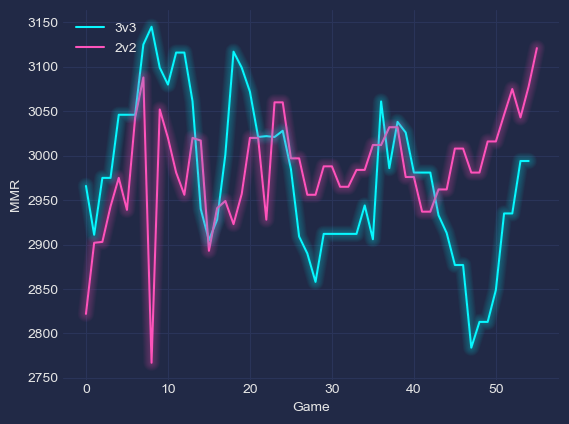

In [203]:
plt.style.use("cyberpunk")

ax = df_3v3.plot(y='mmr_tm_0', label='3v3', ylabel='MMR', xlabel='Game')
df_2v2.plot(y='mmr_tm_0', label='2v2',ax=ax)

ax.legend(loc='upper left')

mplcyberpunk.make_lines_glow()
plt.show()


In [205]:
plt.gcf().get_facecolor()

(0.12941176470588237, 0.1607843137254902, 0.27450980392156865, 1.0)

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='Game', ylabel='APM'>

<Axes: xlabel='Game', ylabel='APM'>

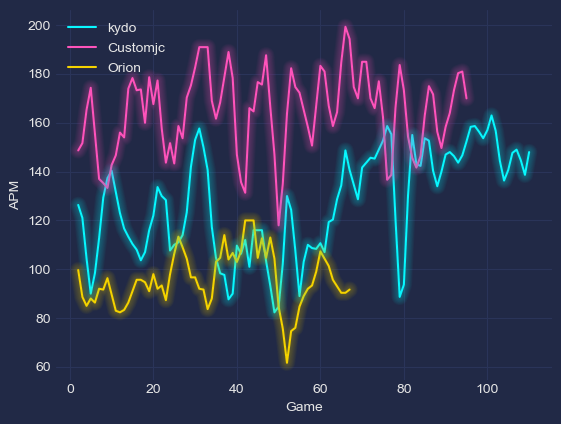

In [72]:
ax = df_k['apm_tm_0'].rolling(3).mean().plot(y='apm_tm_0', label='kydo', ylabel='APM', xlabel='Game')
df_j['apm_tm_0'].rolling(3).mean().plot(y='apm_tm_0',ax=ax, label='Customjc')
df_g['apm_tm_0'].rolling(3).mean().plot(y='apm_tm_0',ax=ax, label='Orion')

ax.legend(loc='upper left')

mplcyberpunk.make_lines_glow()
plt.show()

In [317]:
def button(race):
    
    highlight = Image.open('./graphics/round.png')
    enhancer = ImageEnhance.Brightness(highlight)
    highlight = enhancer.enhance(0.5)
    highlight = highlight.filter(ImageFilter.GaussianBlur(radius=5))
    mask = Image.open('./graphics/round-mask.png')

    icon = Image.open(f'./graphics/{race}_transparent_by_n80sire.png').convert('RGBA')
    enhancer = ImageEnhance.Brightness(icon)
    icon = enhancer.enhance(1.5) 
    button = Image.new('RGBA', mask.size)

    # Resize Icon
    icon = ImageOps.fit(icon, highlight.size, 
                        method=Image.LANCZOS, centering=(0.5, 0.5))

    # Create a helper image that will hold the icon after the reshape
    helper = button.copy()
    # Cut the icon by the shape of the mask
    helper.paste(icon, mask=mask)

    # Fill with a solid color by the mask's shape
    button.paste((0, 0, 0), mask=mask)
    # Get rid of the icon's alpha band
    icon = icon.convert('RGB')
    # Paste the icon on the solid background
    # Note we are using the reshaped icon as a mask
    button.paste(icon, mask=helper)
    
    # Get a copy of the highlight image without the alpha band
    overlay = highlight.copy().convert('RGB')
    button.paste(overlay, mask=highlight)

    return button 
     

def add_corners(im, rad):
    circle = Image.new('L', (rad * 2, rad * 2), 0)
    draw = ImageDraw.Draw(circle)
    draw.ellipse((0, 0, rad * 2 - 1, rad * 2 - 1), fill=255)
    alpha = Image.new('L', im.size, 255)
    w, h = im.size
    alpha.paste(circle.crop((0, 0, rad, rad)), (0, 0))
    alpha.paste(circle.crop((0, rad, rad, rad * 2)), (0, h - rad))
    alpha.paste(circle.crop((rad, 0, rad * 2, rad)), (w - rad, 0))
    alpha.paste(circle.crop((rad, rad, rad * 2, rad * 2)), (w - rad, h - rad))
    im.putalpha(alpha)
    return im

def draw_hexagon(ax, center, radius, color='w'):
        ax.add_patch(
            mpatches.RegularPolygon(
                xy=center,
                numVertices=6,
                radius=radius + 0.2,
                facecolor=color,
                edgecolor="none",
                orientation=0,
                fill=True))

def player_banner(b_text,race):
    
    np.random.seed(2019)

    RADIUS = 2

    # Dimensions of the bounding box of the hexagons
    WIDTH = math.sqrt(3) * RADIUS
    HEIGHT = 2 * RADIUS

    mm_to_in = 0.03937008

    # positions for hexagon
    centers=list()
    for offset_x, offset_y in [(0, 0), (WIDTH / 2, (3 / 2) * RADIUS)]:
        rows = np.arange(start=offset_x, stop=105, step=WIDTH)
        columns = np.arange(start=offset_y, stop=105, step=3 * RADIUS)
        for x, y in itertools.product(rows, columns):
            centers.append((x,y))

    colormap = plt.get_cmap('plasma')

    figure, ax = plt.subplots(1, 1, 
                            figsize=(100 * mm_to_in, 100 * mm_to_in), 
                            frameon=False)
    for (x,y) in centers:
        # radius away from bottom left corner
        # proportional to the distance of the top right corner
        # i.e. 0 < r < 1
        r = math.hypot(x, y) / math.hypot(100, 100)
        draw_hexagon(ax, center=(x, y), radius=RADIUS, color=colormap(r + random.gauss(0, 0.01)))


    # Dimensions of the page in mm
    ax.set_xlim([0, 100])
    ax.set_ylim([0, 100])
    ax.axis("off")



    image_xaxis = 0.05
    image_yaxis = 0.10
    image_width = 0.25
    image_height = 0.25  # Same as width since our logo is a square

    ax_image = figure.add_axes([image_xaxis,
                            image_yaxis,
                            image_width,
                            image_height]
                        )

    # Display the image
    badge = button(race)
    ax_image.imshow(badge)
    ax_image.axis('off')  # Remove axis of the image

    ax_t = figure.add_axes([0,0,1,1])
    ax_t.text(0.25, 0.15, b_text, fontname='fantasy', fontweight='extra bold', fontsize=44, va='center')
    ax_t.axis('off')

    # 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'
    plt.subplots_adjust(top=1, bottom=0, left=0, right=1)
    plt.show()
    figure.savefig(f'./graphics/{b_text}.png')

    banner = Image.open(f'./graphics/{b_text}.png')
    banner = banner.crop((0,250,393,375))
    banner = add_corners(banner, 20)
    banner.save(f'./graphics/{b_text}.png')

    return banner
    





In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
import sc2stats


c:\Users\murph\miniconda3\envs\sc2stats\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25343 (\N{CJK UNIFIED IDEOGRAPH-62FF}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\murph\miniconda3\envs\sc2stats\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 33879 (\N{CJK UNIFIED IDEOGRAPH-8457}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\murph\miniconda3\envs\sc2stats\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38512 (\N{CJK UNIFIED IDEOGRAPH-9670}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\murph\miniconda3\envs\sc2stats\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27611 (\N{CJK UNIFIED IDEOGRAPH-6BDB}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\murph\miniconda3\envs\sc2stats\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30070 (\N{CJK UNIFI

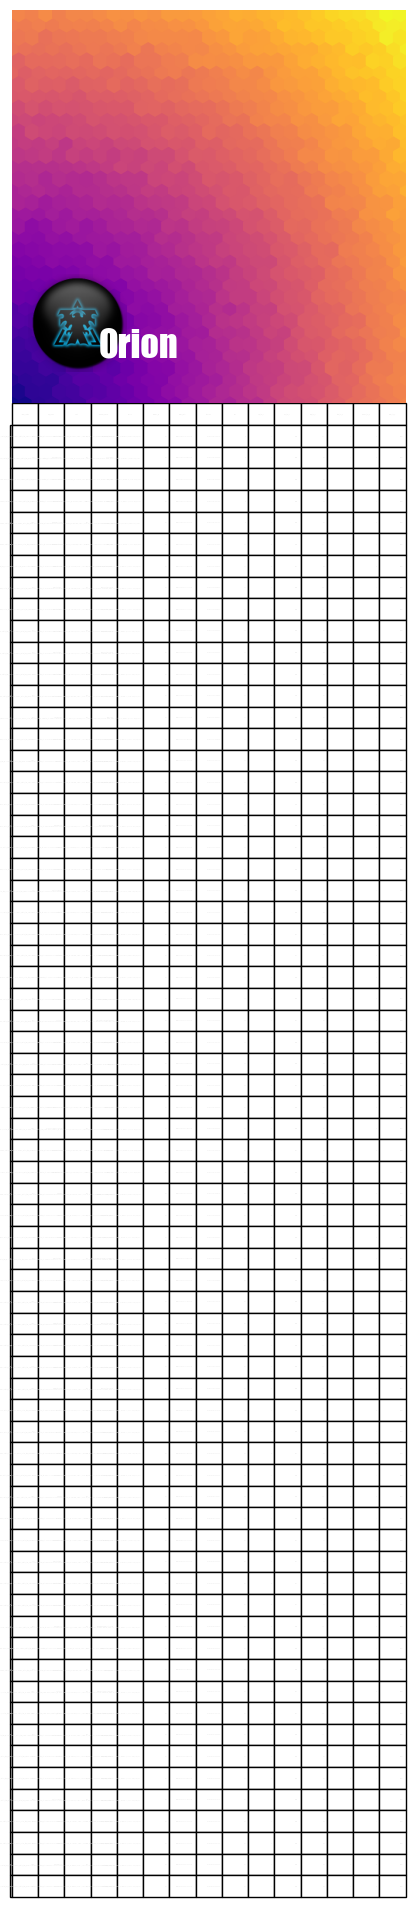

d:\GitHub\sc2stats\sc2stats\graphics.py:162: UserWarning: Glyph 25343 (\N{CJK UNIFIED IDEOGRAPH-62FF}) missing from font(s) Arial.
  figure.savefig(f'./graphics/{b_text}.png')
d:\GitHub\sc2stats\sc2stats\graphics.py:162: UserWarning: Glyph 33879 (\N{CJK UNIFIED IDEOGRAPH-8457}) missing from font(s) Arial.
  figure.savefig(f'./graphics/{b_text}.png')
d:\GitHub\sc2stats\sc2stats\graphics.py:162: UserWarning: Glyph 38512 (\N{CJK UNIFIED IDEOGRAPH-9670}) missing from font(s) Arial.
  figure.savefig(f'./graphics/{b_text}.png')
d:\GitHub\sc2stats\sc2stats\graphics.py:162: UserWarning: Glyph 27611 (\N{CJK UNIFIED IDEOGRAPH-6BDB}) missing from font(s) Arial.
  figure.savefig(f'./graphics/{b_text}.png')
d:\GitHub\sc2stats\sc2stats\graphics.py:162: UserWarning: Glyph 30070 (\N{CJK UNIFIED IDEOGRAPH-7576}) missing from font(s) Arial.
  figure.savefig(f'./graphics/{b_text}.png')
d:\GitHub\sc2stats\sc2stats\graphics.py:162: UserWarning: Glyph 20196 (\N{CJK UNIFIED IDEOGRAPH-4EE4}) missing from font

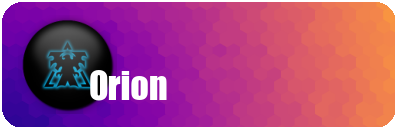

In [117]:
sc2stats.graphics.player_banner('Orion','terran',corner_boarder=True, p_df=df_g)
#sc2stats.graphics.player_banner('CustomJC','protoss',corner_boarder=True)
#sc2stats.graphics.player_banner('kydo','zerg',corner_boarder=True)

In [78]:
df_j

,game_length,map_name,format,winning_player,players,seasons_id,replay_date,DateTime,DOY,race_tm_0,mmr_tm_0,apm_tm_0,team_tm_0,winner_tm_0,name_tm_0
0,844.5,Megastructure,3v3,"chris,CKWI,Starphyre",[{'player': {'players_replays_url': 'https://s...,62,2025-01-05T17:50:12-07:00,2025-01-05 17:50:12,5,P,2966,184,2,0,Customjc
1,1166.0,Breakwater LE,2v2,"Richarger,TheBeyonder",[{'player': {'players_replays_url': 'https://s...,62,2025-01-05T18:15:19-07:00,2025-01-05 18:15:19,5,P,2822,152,2,0,Customjc
2,299.5,Sandstorm CE,3v3,"Philly,cyberchronic,PjtheAwesome",[{'player': {'players_replays_url': 'https://s...,62,2025-01-10T19:49:36-07:00,2025-01-10 19:49:36,10,P,2911,110,1,0,Customjc
3,943.5,Megastructure,3v3,"Orion,Customjc,kydo",[{'player': {'players_replays_url': 'https://s...,62,2025-01-10T20:49:27-07:00,2025-01-10 20:49:27,10,P,2975,193,2,1,Customjc
4,943.5,Megastructure,3v3,"Orion,Customjc,kydo",[{'player': {'players_replays_url': 'https://s...,62,2025-01-10T20:49:27-07:00,2025-01-10 20:49:27,10,P,2975,193,2,1,Customjc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,1014.5,Emerald City CE,2v2,"Customjc,kydo",[{'player': {'players_replays_url': 'https://s...,62,2025-02-23T18:02:56-07:00,2025-02-23 18:02:56,54,P,3046,158,1,1,Customjc
92,895.0,Rohana LE,2v2,"Richarger,TheBeyonder",[{'player': {'players_replays_url': 'https://s...,62,2025-02-23T18:18:24-07:00,2025-02-23 18:18:24,54,P,3075,195,2,0,Customjc
93,476.0,Yellowjacket,2v2,"Customjc,kydo",[{'player': {'players_replays_url': 'https://s...,62,2025-02-23T18:28:37-07:00,2025-02-23 18:28:37,54,P,3043,188,1,1,Customjc
94,637.5,Yellowjacket,2v2,"Customjc,kydo",[{'player': {'players_replays_url': 'https://s...,62,2025-02-23T18:40:33-07:00,2025-02-23 18:40:33,54,P,3078,160,1,1,Customjc


In [ ]:
usr = df_g

apm_max = usr['apm_tm_0'].max()
apm_min = usr['apm_tm_0'].min()
apm_avg = int(usr['apm_tm_0'].mean())
wrt = usr[usr['winner_tm_0'] == 1]['winner_tm_0'].count()/df.shape[0]

usr_dict = {'Max APM':f'{apm_max}', 'Min APM':f'{apm_min}', 'Avg APM':f'{apm_avg}', 'Win Rate':f"{wrt:0.2}"}

usr_df = pd.Series(usr_dict, name='Stats').to_frame().reset_index(names='')

<table>
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Stats</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Max APM</td>
      <td>214</td>
    </tr>
    <tr>
      <td>Min APM</td>
      <td>62</td>
    </tr>
    <tr>
      <td>Avg APG</td>
      <td>164</td>
    </tr>
    <tr>
      <td>Win Rate</td>
      <td>0.53</td>
    </tr>
  </tbody>
</table>


In [196]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': ['-layers', 'OptimizePlus'],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': True,
          'axes.edgecolor': 'black',
          'axes.facecolor': '#212946',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': True,
          'axes.grid.axis': 'bo

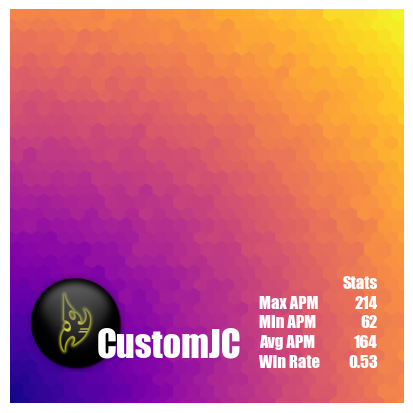

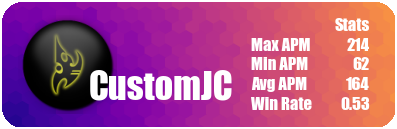

In [209]:
import sc2stats
usr = df_j
nm = 'CustomJC'
rc = 'protoss'

apm_max = usr['apm_tm_0'].max()
apm_min = usr['apm_tm_0'].min()
apm_avg = int(usr['apm_tm_0'].mean())
wrt = usr[usr['winner_tm_0'] == 1]['winner_tm_0'].count()/df.shape[0]

usr_dict = {'Max APM':f'{apm_max}', 'Min APM':f'{apm_min}', 'Avg APM':f'{apm_avg}', 'Win Rate':f"{wrt:0.2}"}

usr_df = pd.Series(usr_dict, name='Stats').to_frame().reset_index(names='')
sc2stats.graphics.player_banner(nm,rc,corner_boarder=True, p_df=usr_df.set_index(''))

In [2]:
import http.client
import json

conn = http.client.HTTPSConnection('sc2replaystats.com')
headers = {
    'Accept': 'application/json, text/plain, */*',
    'Accept-Language': 'en-US,en;q=0.9',
    'Connection': 'keep-alive',
    'Content-Type': 'multipart/form-data; boundary=----WebKitFormBoundarynxa5bdrOPoHKTDAk',
    'Origin': 'https://sc2replaystats.com',
    'Referer': 'https://sc2replaystats.com/account/display/77320/0/2861968/2v2/AutoMM/62/',
    }
conn.request(
    'POST',
    '/stats/runReport',
    '------WebKitFormBoundarynxa5bdrOPoHKTDAk\r\nContent-Disposition: form-data; name="request"\r\n\r\n{"metrics":["player_name","player_apm","player_units_killed","player_units","player_workers","player_workers_killed","player_time_supply_blocked","player_avg_unspent_resources","player_mmr","player_race","player_resources_lost_minerals"],"group_bys":["player_id"],"filters":{"account_id":{"logic":"equal","value":"77320"},"game_type":{"logic":"equal","value":"AutoMM"},"format":{"logic":"equal","value":"2v2"},"player_id":{"logic":"in","value":"2861968"},"last_replay":{"logic":"relative","value":"last_replay"}},"order":[{"player_id":""}],"limit":null,"date":"last_replay:last_replay","settings":{"account_id":77320}}\r\n------WebKitFormBoundarynxa5bdrOPoHKTDAk--\r\n',
    headers
)
response = conn.getresponse()

In [3]:

a = json.loads(response.read().decode())

In [82]:
df.columns

Index(['player_name', 'player_apm', 'player_units_killed', 'player_units',
       'player_workers', 'player_workers_killed', 'player_time_supply_blocked',
       'player_avg_unspent_resources', 'player_mmr', 'player_race',
       'player_resources_lost_minerals', 'player_id', 'player'],
      dtype='object')

In [ ]:
df = pd.DataFrame(a['results']['data'])
df['player'] = np.ones(df.shape[0])
col_order = ['player','player_mmr','player_apm','player_workers','player_workers_killed',
             'player_units','player_units_killed','player_avg_unspent_resources','player_resources_lost_minerals','player_time_supply_blocked']

df.drop(columns=['player_race','player_id'])[col_order]


,player,player_mmr,player_apm,player_workers,player_workers_killed,player_units,player_units_killed,player_avg_unspent_resources,player_resources_lost_minerals,player_time_supply_blocked
0,1.0,2983,113,59,22,409,110,843,10487,43
1,1.0,3129,209,79,6,211,91,686,7390,29
2,1.0,3129,181,101,35,745,186,749,11112,36
3,1.0,2983,120,74,14,187,151,1126,13100,50


In [85]:
pd.DataFrame(a['results']['data'])

,player_name,player_apm,player_units_killed,player_units,player_workers,player_workers_killed,player_time_supply_blocked,player_avg_unspent_resources,player_mmr,player_race,player_resources_lost_minerals,player_id
0,KickHimPedro,113,110,409,59,22,43,843,2983,Z,10487,158256
1,Customjc,209,91,211,79,6,29,686,3129,P,7390,986077
2,kydo,181,186,745,101,35,36,749,3129,Z,11112,2861968
3,pwomq,120,151,187,74,14,50,1126,2983,P,13100,3454671


In [ ]:
import pandas as pd

col_order = reversed(['player','player_mmr','player_apm','player_workers','player_workers_killed',
             'player_units','player_units_killed','player_avg_unspent_resources','player_resources_lost_minerals','player_time_supply_blocked','player_name'])

df = pd.DataFrame(a['results']['data'])
df['player'] = np.ones(df.shape[0])
df = df.drop(columns=['player_race','player_id'])
df = df[col_order]

df = df.set_index('player_name').transpose()[['Customjc','kydo','KickHimPedro','pwomq']]

df_plot = df.apply(lambda x: x*100/sum(x), axis=1)
df.loc['player'] = df.columns

C:\Users\murph\AppData\Local\Temp\ipykernel_23716\4108736741.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Customjc' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc['player'] = df.columns
C:\Users\murph\AppData\Local\Temp\ipykernel_23716\4108736741.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'kydo' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc['player'] = df.columns
C:\Users\murph\AppData\Local\Temp\ipykernel_23716\4108736741.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'KickHimPedro' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc['player'] = df.columns
C:\Users\murph\A

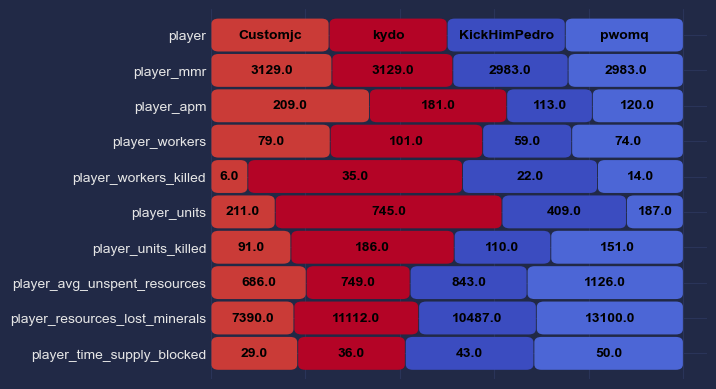

In [94]:
import matplotlib as mpl
from matplotlib.patches import FancyBboxPatch

cmap = mpl.colormaps['coolwarm']
colors = cmap([240,255,0,15])

plt.style.use("cyberpunk")
#df_plot = df.apply(lambda x: x*100/sum(x), axis=1)

ax = df_plot.plot(kind="barh", stacked=True, width=0.95,color=colors,legend=False)
#l4 = plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
#                mode="expand", borderaxespad=0, ncol=4)

cols = df_plot.columns

new_patches = []
for patch in reversed(ax.patches):
    bb = patch.get_bbox()
    color=patch.get_facecolor()
    p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                        abs(bb.width), abs(bb.height),
                        boxstyle="round,pad=-0.1,rounding_size=1.5",
                        ec="none", fc=color,
                        mutation_aspect=0.1
                        )
    patch.remove()
    new_patches.append(p_bbox)
for patch in new_patches:
    ax.add_patch(patch)

for c, col in zip(ax.containers, cols):
    
#    # get the values for the column from df
    vals = df[col]
#
#    # create a custom label for bar_label
    labels = [f'{val}' if (w := v.get_width()) > 0 else '' for v, val in zip(c, vals)]
#    
#    # annotate each section with the custom labels
    ax.bar_label(c, labels=labels, label_type='center', fontweight='bold',color='black')

ax.axes.xaxis.set_ticklabels([])
#mplcyberpunk.add_bar_gradient(bars=ax.containers[0].get_children())
plt.show()

col_order = ['player','player_mmr','player_apm','player_workers','player_workers_killed',
             'player_units','player_units_killed','player_avg_unspent_resources','player_resources_lost_minerals','player_time_supply_blocked']